In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scvi
import scanpy as sc
import re
from scipy import sparse


Global seed set to 0
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new_ivy/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new_ivy/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
cur_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/out/"
new_out_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/plots/"

references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"


In [3]:
##load data
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")

##remove combat dataset 
adata.shape

(363300, 23789)

In [4]:
conditions = [
        (adata.obs["orig.ident"] == "SeuratProject"), 
        (adata.obs["orig.ident"] != "SeuratProject"), 
    ]
#create a list of the values we want to assign for each condition

values = [adata.obs["sample_ID"], adata.obs["lane"]]
    
adata.obs["sequencing_batch"] = np.select(conditions, values)

set(adata.obs["sequencing_batch"])

{'E2L1_azimuth',
 'E2L2_azimuth',
 'E2L3_azimuth',
 'E2L4_azimuth',
 'E2L5_azimuth',
 'E2L6_azimuth',
 'E2L7_azimuth',
 'E2L8_azimuth',
 'HBV_C',
 'HBV_Tre_1',
 'HBV_Tre_2',
 'HBV_Tre_3',
 'HBV_X2',
 'HH_Tre_4',
 'HIVHBV_C',
 'HIVHBV_Tre_5',
 'HIVHBV_X2',
 'Healthy',
 'L1_azimuth',
 'L2_azimuth',
 'L3_azimuth',
 'L4_azimuth',
 'L5_azimuth'}

In [5]:
tmp = adata.obs[["sample_ID","donor"]].bfill(axis=1).iloc[:, 0]
tmp

adata.obs["batch"] = tmp.copy()

In [6]:
##assign batch for azimuth and combat
conditions = [
    (adata.obs["orig.ident"].isin(["SeuratProject"])),
    (~adata.obs["orig.ident"].isin(["SeuratProject"])),
 ]

# create a list of the values we want to assign for each condition
values = [adata.obs["sample_ID"], adata.obs["orig.ident"]]

# create a new column and use np.select to assign values to it using our lists as arguments
adata.obs["scvi_batch"] = np.select(conditions, values)
adata.obs["scvi_batch"].unique().tolist()

['HIVHBV_C',
 'HH_Tre_4',
 'HBV_Tre_1',
 'HIVHBV_Tre_5',
 'HBV_Tre_3',
 'HBV_X2',
 'HBV_C',
 'HIVHBV_X2',
 'HBV_Tre_2',
 'Healthy',
 'P2_7',
 'P1_7',
 'P4_3',
 'P4_7',
 'P1_3',
 'P1_0',
 'P2_3',
 'P4_0',
 'P2_0',
 'P5_7',
 'P8_0',
 'P8_7',
 'P8_3',
 'P5_3',
 'P5_0']

## Prepare SCVI

In [7]:
##assign counts layer 
adata.layers["counts"] = adata.X.copy()


In [8]:
## HVG
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    batch_key="sequencing_batch",
    flavor = "seurat_v3",
    subset=True)  

In [9]:
scvi.model.SCVI.setup_anndata(
  adata,
  batch_key="scvi_batch",
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
#sc.pp.subsample(adata, n_obs=10000, random_state=0)

In [11]:
N_EPOCHS=500

scvi.settings.seed = 0

early_stopping_kwargs = {
        "early_stopping": True,
        "early_stopping_monitor": "elbo_validation",
        "early_stopping_patience": 10,
        "early_stopping_min_delta": 0.001,
        }

vae = scvi.model.SCVI(
    adata,
    n_latent = 20,
)

vae.train(max_epochs=N_EPOCHS, batch_size=1024, **early_stopping_kwargs) #lr=4e-3)



Global seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 355/500:  71%|████▉  | 355/500 [31:58<13:03,  5.40s/it, loss=449, v_num=1]
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 452.636. Signaling Trainer to stop.


In [12]:
vae.save("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/updated_model", save_anndata=True,overwrite=True)


In [13]:
##generate latent space and run umap

adata.obsm["X_scVI"] = vae.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scVI", metric="cosine",n_neighbors=30)



2022-12-16 02:27:10.419167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/eb/2020b/ivybridge/software/Arrow/6.0.0-foss-2021b/lib:/apps/eb/2020b/ivybridge/software/Boost/1.77.0-GCC-11.2.0/lib:/apps/eb/2020b/ivybridge/software/R/4.1.2-foss-2021b/lib/R/lib:/apps/eb/2020b/ivybridge/software/libgit2/1.1.1-GCCcore-11.2.0/lib:/apps/eb/2020b/ivybridge/software/MPFR/4.1.0-GCCcore-11.2.0/lib:/apps/eb/2020b/ivybridge/software/GDAL/3.3.2-foss-2021b/lib:/apps/eb/2020b/ivybridge/software/HDF/4.2.15-GCCcore-11.2.0/lib:/apps/eb/2020b/ivybridge/software/libtirpc/1.3.2-GCCcore-11.2.0/lib:/apps/eb/2020b/ivybridge/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/core/lib:/apps/eb/2020b/ivybridge/software/libgeotiff/1.7.0-GCCcore-11.2.0/lib:/apps/eb/2020b/ivybridge/software/PROJ/8.1.0-GCCcore-11

In [14]:
sc.tl.umap(adata)

/gpfs2/well/immune-rep/users/vbw431/python/scvi_new_ivy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


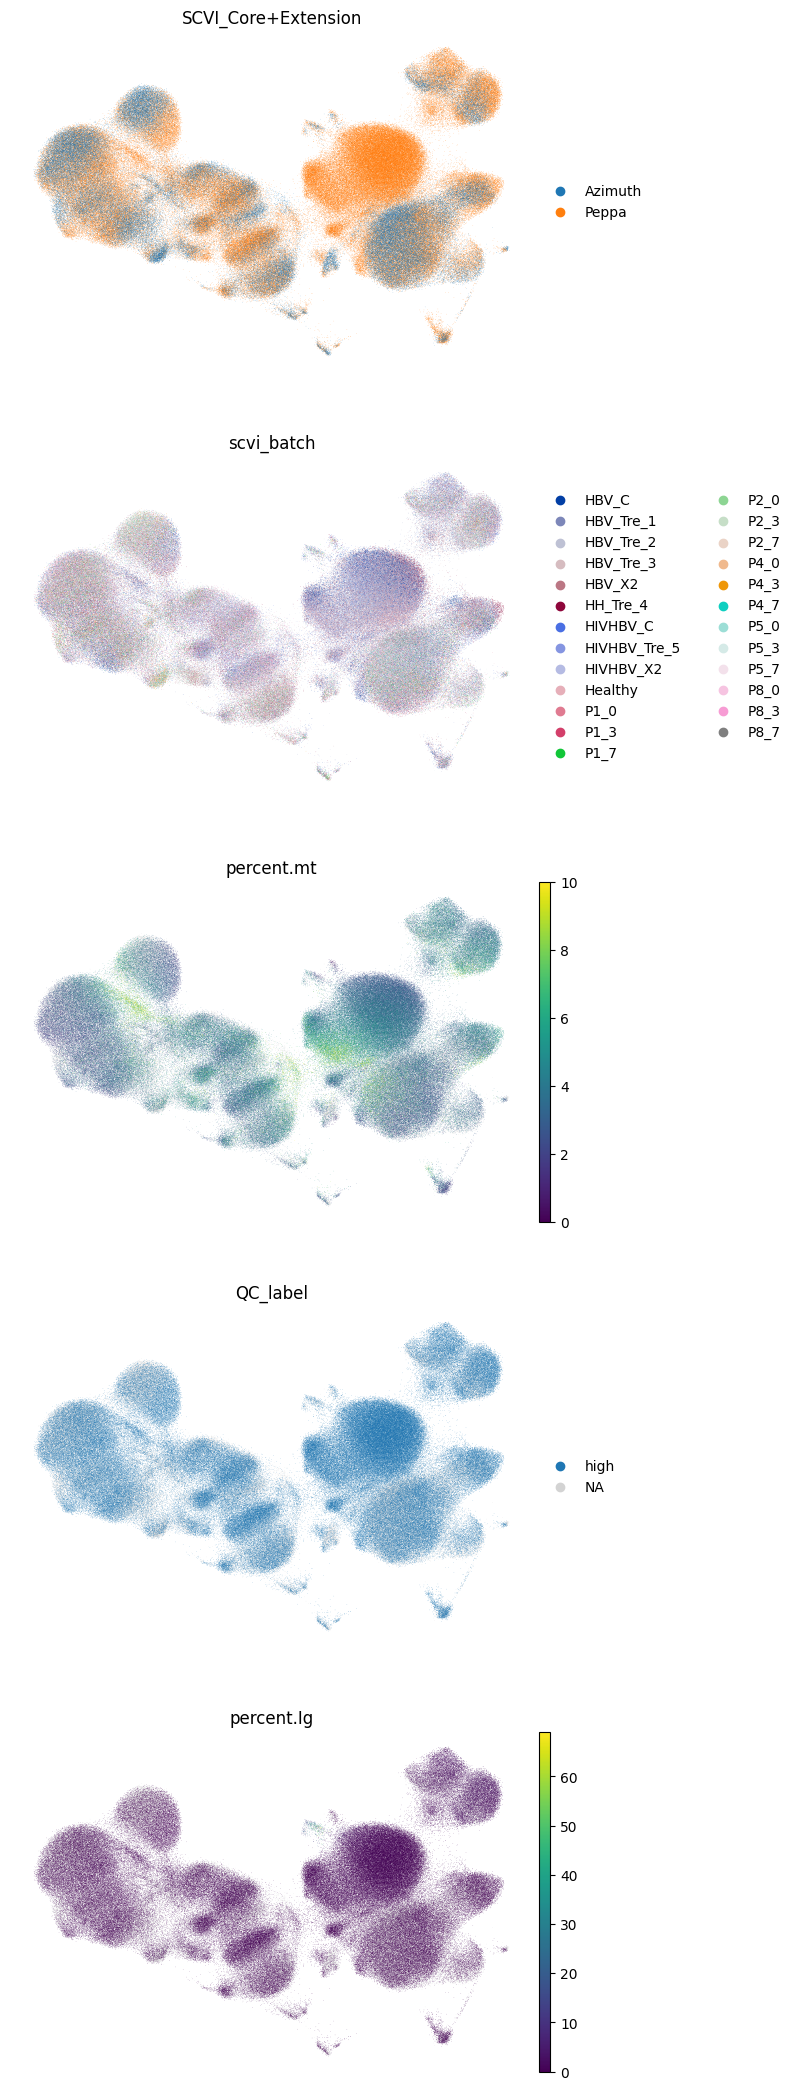

<Figure size 640x480 with 0 Axes>

In [15]:
##plot umap

with plt.rc_context():
  sc.pl.umap(
    adata,
    color=["Ref_lab", "scvi_batch","percent.mt", "QC_label", "percent.Ig"],
    frameon=False,
    ncols=1,
    title="SCVI_Core+Extension",
  #     legend_fontoutline=1,
  #     size=5,
  )
  plt.savefig(plot_dir+"/SCVI_peppa_azimuth_umap.png", bbox_inches="tight", dpi=300)


In [20]:
##save

adata.write_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/Peppa_azimuth_SCVI.h5ad")


In [17]:
set(adata.obs["batch"])

{'HBV_C',
 'HBV_Tre_1',
 'HBV_Tre_2',
 'HBV_Tre_3',
 'HBV_X2',
 'HH_Tre_4',
 'HIVHBV_C',
 'HIVHBV_Tre_5',
 'HIVHBV_X2',
 'Healthy',
 'P1',
 'P2',
 'P4',
 'P5',
 'P8'}

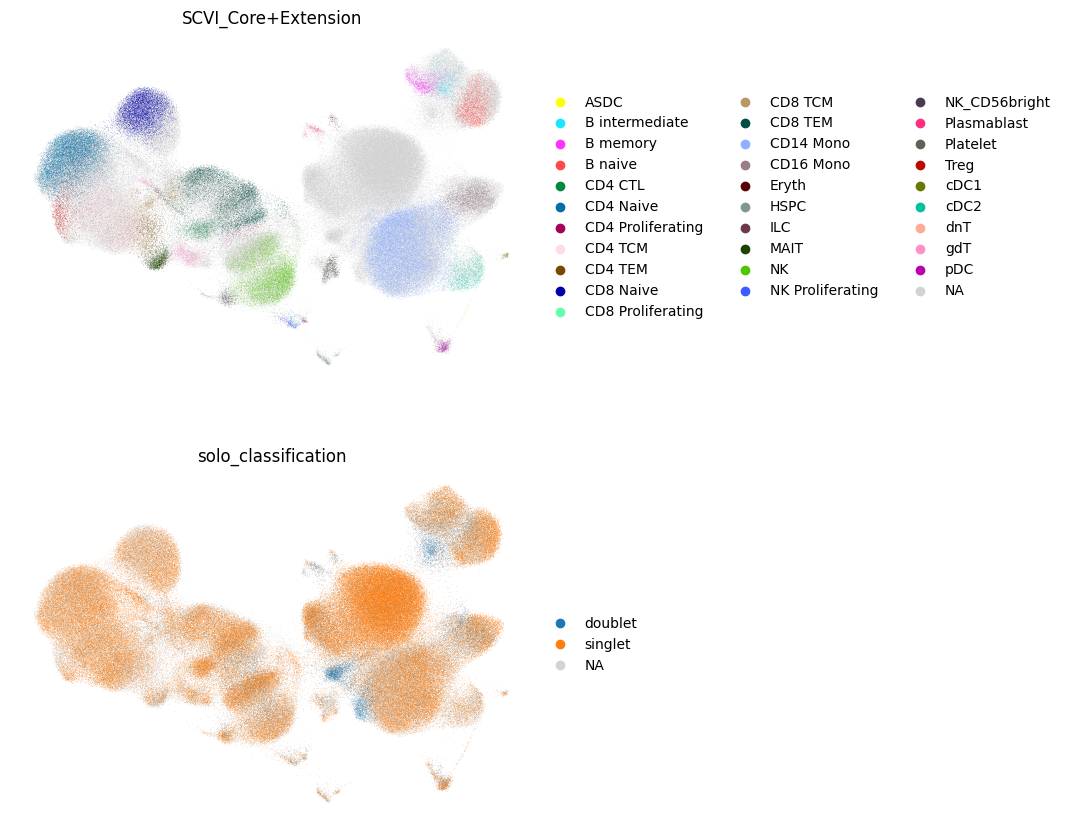

In [18]:
sc.pl.umap(
    adata,
    color=["celltype.l2", "solo_classification"],
    #groups=["Healthy"],
    frameon=False,
    ncols=1,
    title="SCVI_Core+Extension",
  #     legend_fontoutline=1,
  #size=15,
  )

In [19]:
adata.obs["scvi_batch"].value_counts()

HIVHBV_Tre_5    31482
HBV_Tre_3       30141
HBV_Tre_1       29884
Healthy         29060
HBV_C           28295
HH_Tre_4        27939
HBV_Tre_2       24672
HBV_X2          24447
HIVHBV_C        21836
HIVHBV_X2       20856
P8_3             8289
P8_0             8135
P5_7             7276
P8_7             7165
P5_3             6359
P5_0             6322
P1_0             6243
P4_7             5871
P2_0             5791
P1_3             5758
P4_3             5686
P1_7             5645
P2_3             5562
P2_7             5365
P4_0             5221
Name: scvi_batch, dtype: int64